In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: zhaoyang shi
"""

In [27]:
import numpy               as np
import tensorflow          as tf
import tensorflow_addons   as tfa
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd


from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


import tensorflow_manopt as manopt

# cylinder 

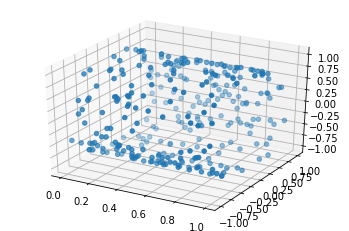

In [28]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300)

noise = 0
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)
#add noise if you want


rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
plt.show()

# 2 cylinders

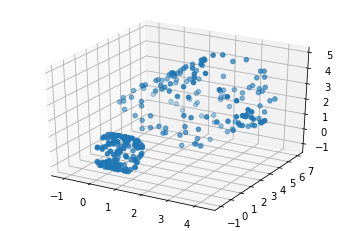

In [46]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,150)
noise=np.random.normal(0,0.1,150)

noise=0
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)
#add noise if you want


rr3=np.random.uniform(0,1,150) #a point (xx,yy,rr3) on 3D

np.random.seed(100)
sss3=np.random.uniform(0,2*np.pi,150)
xxx=3+2*np.cos(sss3)
yyy=2*np.sin(sss3)

xxx45=2+xxx


rrr3=np.random.uniform(0,5,150) #a point (xx,yy,rr3) on 3D

#rotate by 45 degree
rrr45=rrr3*np.sqrt(2)/2-np.sqrt(2)/2*yyy
yyy45=rrr3*np.sqrt(2)/2+np.sqrt(2)/2*yyy

RR=np.r_[rr3,rrr45]
RX=np.r_[xx,xxx]
RY=np.r_[yy,yyy]

RX45=np.r_[xx,xxx45]
RY45=np.r_[yy,yyy45]

ax = plt.subplot(111, projection='3d')
ax.scatter(RR,RX45,RY45) 
plt.show()

# date X

In [47]:
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
X=np.array(np.mat([RR,RX45,RY45]).T,dtype=np.float32)

# construct persistence diagrams into tensorflow form

In [30]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    def call(self):
        m, d, c = self.mel, self.dim, self.card
        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        Z=X@self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

# show persistence diagrams

In [32]:
st = gd.RipsComplex(points = X, 
                    max_edge_length = 10).create_simplex_tree(max_dimension=2)
st.persistence()
D = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)

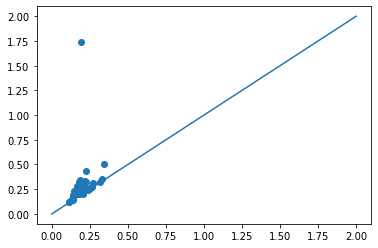

In [33]:
plt.figure()
plt.scatter(D[:,0], D[:,1])
plt.plot([0,2], [0,2])
plt.show()

In [34]:
st1 = gd.RipsComplex(points = X@np.array([[0,  0],
       [1 , -0 ],
       [ 0. , 1]]), 
                    max_edge_length=12).create_simplex_tree(max_dimension=2)
#the perfect circle case
st1.persistence()
D1 = np.array(st1.persistence_intervals_in_dimension(1), dtype=np.float32)

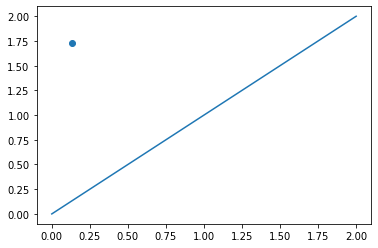

In [35]:
plt.figure()
plt.scatter(D1[:,0], D1[:,1])
plt.plot([0,2], [0,2])
plt.show()

In [36]:
wasserstein_distance(tf.constant(D1), tf.constant(D), order=2, internal_p=2)

0.3735210814701848

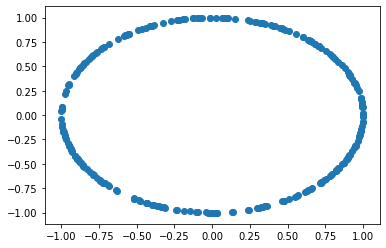

In [37]:
data=X@np.array([[0,  0],
       [1 , 0 ],
       [ 0. , 1]])
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

# Sinkhorn with lr=10 fixed

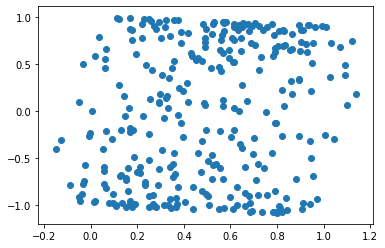

In [38]:
#construct Stiefel manifold
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

#random P in Stiefel manifold as the initialized
H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''

#convert it into tensor with float 32
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

#assign the initialized P
manopt.variable.assign_to_manifold(P, S)

#construct main model and optimization model
model = RipsModel(P=P, mel=12, dim=1, card = 20)

opt = manopt.optimizers.RiemannianSGD(learning_rate= 10)

#show the initialized transformed data
data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

0.09505963


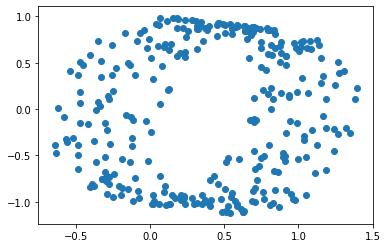

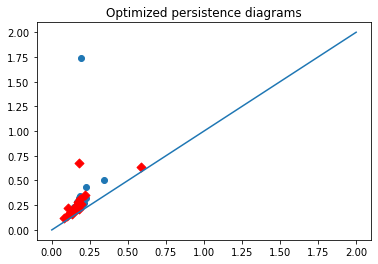

0.06988244


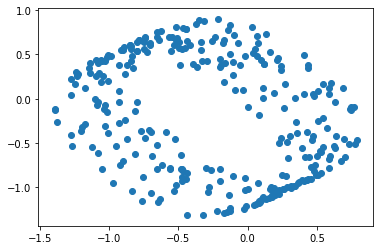

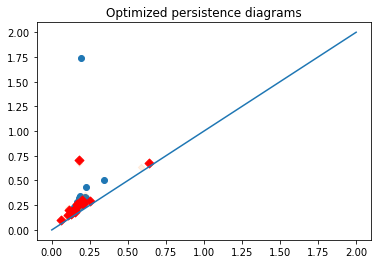

0.069063276


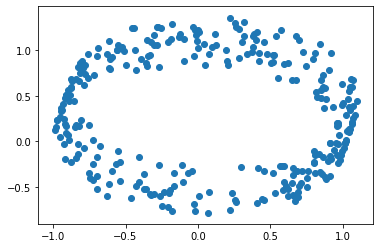

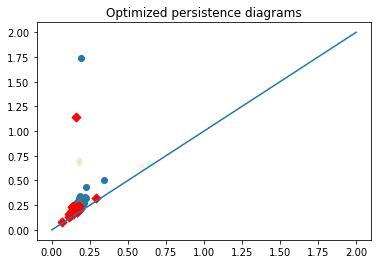

0.03654422


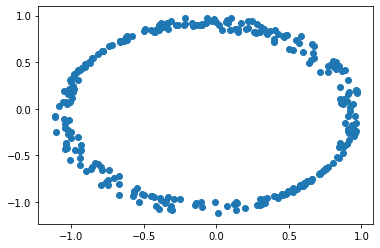

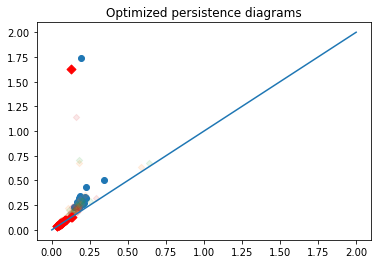

0.06254214


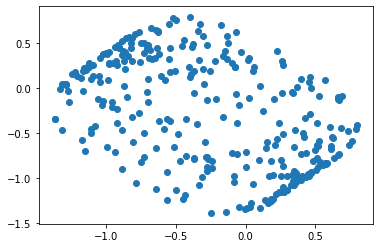

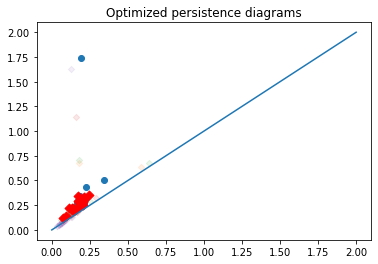

In [40]:
#keep track of loss and persistence diagrams after projection
losses, dgms = [], []

lr = 10
for epoch in range(4+1):#learning iteration
    #opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    #lr = 0.05*lr

    with tf.GradientTape() as tape:#computing gradient
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        npX = np.array(Xdgm)
        npZ = np.array(Zdgm)
        
        #computing Sinkhorn distance
        def dmat(x, y):
            """
            :param x: (na, 2)
            :param y: (nb, 2)
            :return:
            """
            mmp1 = tf.tile(tf.expand_dims(x, axis=1), [1, y.shape[0], 1])  # (na, nb, 2)
            mmp2 = tf.tile(tf.expand_dims(y, axis=0), [x.shape[0], 1, 1])  # (na, nb, 2)

            mm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(mmp1, mmp2)), axis=2))  # (na, nb)

            return mm
        
        def sink(M, m_size, reg, numItermax=1000, stopThr=1e-9):
            # we assume that no distances are null except those of the diagonal of distances
            # M: extended cost matrix
            # reg: lambda

            a = tf.expand_dims(tf.ones(shape=(m_size[0],)) / m_size[0], axis=1)  # (na, 1)
            b = tf.expand_dims(tf.ones(shape=(m_size[1],)) / m_size[1], axis=1)  # (nb, 1)

            # init data
            Nini = m_size[0]
            Nfin = m_size[1]

            u = tf.expand_dims(tf.ones(Nini) / Nini, axis=1)  # (na, 1)
            v = tf.expand_dims(tf.ones(Nfin) / Nfin, axis=1)  # (nb, 1)

            K = tf.exp(-M / reg)  # (na, nb)

            Kp = (1.0 / a) * K  # (na, 1) * (na, nb) = (na, nb)

            cpt = tf.constant(0)
            err = tf.constant(1.0)

            c = lambda cpt, u, v, err: tf.logical_and(cpt < numItermax, err > stopThr)

            def err_f1():
                # we can speed up the process by checking for the error only all the 10th iterations
                transp = u * (K * tf.squeeze(v))  # (na, 1) * ((na, nb) * (nb,)) = (na, nb)
                err_ = tf.pow(tf.norm(tf.reduce_sum(transp) - b, ord=1), 2)  # (,)
                return err_

            def err_f2():
                return err

            def loop_func(cpt, u, v, err):
                KtransposeU = tf.matmul(tf.transpose(K, (1, 0)), u)  # (nb, na) x (na, 1) = (nb, 1)
                v = tf.compat.v1.div(b,KtransposeU)  # (nb, 1)
                u = 1.0 / tf.matmul(Kp, v)  # (na, 1)

                err = tf.cond(tf.equal(cpt % 10, 0), err_f1, err_f2)

                cpt = tf.add(cpt, 1)
                return cpt, u, v, err

            _, u, v, _ = tf.while_loop(c, loop_func, loop_vars=[cpt, u, v, err])

            result = tf.reduce_sum(u * K * tf.reshape(v, (1, -1)) * M)

            return result
        
        A=np.array([[1,-1],[-1,1]])
        # Compute persistence diagram

        
        # Loss is sum of squares of distances to the diagonal
        Morginal = dmat(Xdgm,Zdgm)
        
        n1,n2 = Morginal.shape
        Deltax=np.zeros(shape=(n1,1))
        Deltaz=np.zeros(shape=(1,n2+1))
        
        for i in range(n1):
            Deltax[i,0] = 1/2*npX[i,:]@A@npX[i,:].T
            
        for j in range(n2):
            Deltaz[0,j] = 1/2*npZ[j,:]@A@npZ[j,:].T
            

        M=tf.square(tf.concat([tf.concat([Morginal,Deltax],1),Deltaz],0))
        
        # Sinkhorn distance as loss
        loss = sink(M,(n1+1,n2+1),0.05)
        

    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    #loss
    print(loss.numpy())
    
    #persistence diagrams after transformation
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

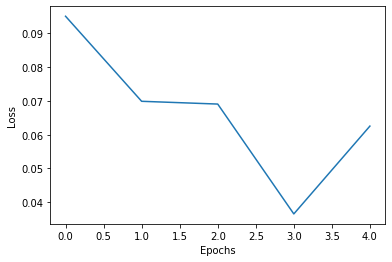

In [41]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Sinkhorn with lr=15 decaying 0.05 rate

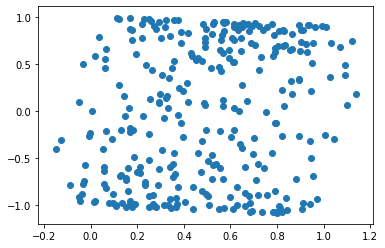

In [42]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 20)

opt = manopt.optimizers.RiemannianSGD(learning_rate= 10)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

0.09505963


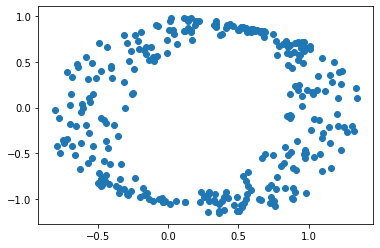

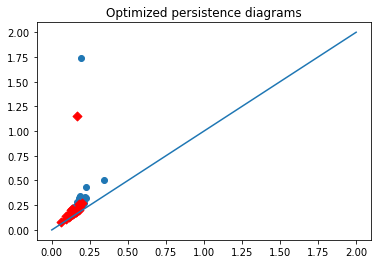

0.039388098


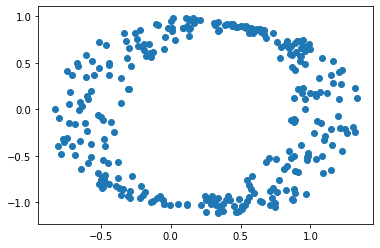

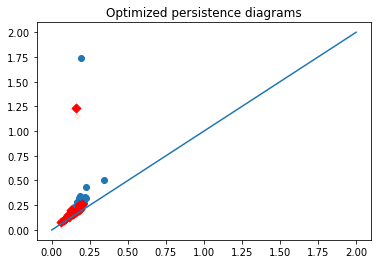

0.036963813


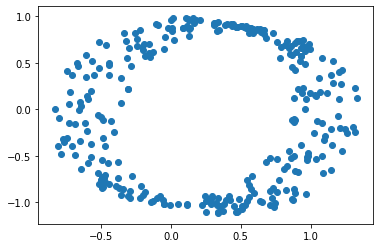

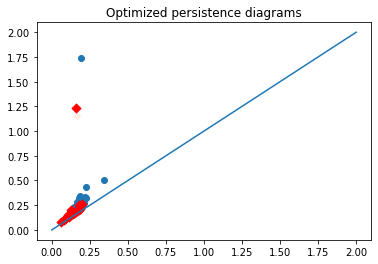

0.03686823


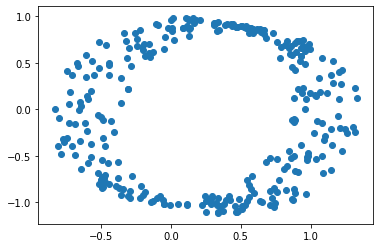

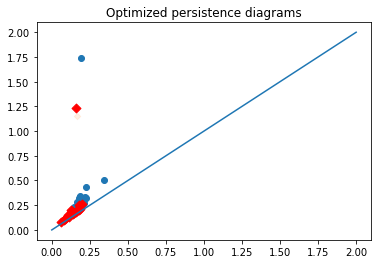

0.036863565


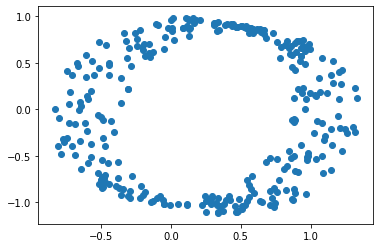

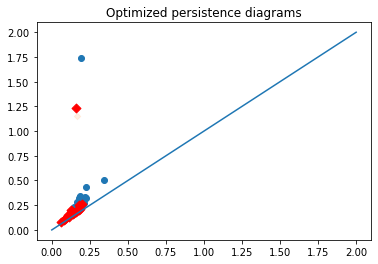

In [43]:
losses, dgms = [], []
lr = 15
for epoch in range(4+1):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    #decaying lr
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        npX = np.array(Xdgm)
        npZ = np.array(Zdgm)
                
        def dmat(x, y):
            """
            :param x: (na, 2)
            :param y: (nb, 2)
            :return:
            """
            mmp1 = tf.tile(tf.expand_dims(x, axis=1), [1, y.shape[0], 1])  # (na, nb, 2)
            mmp2 = tf.tile(tf.expand_dims(y, axis=0), [x.shape[0], 1, 1])  # (na, nb, 2)

            mm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(mmp1, mmp2)), axis=2))  # (na, nb)

            return mm
        
        def sink(M, m_size, reg, numItermax=1000, stopThr=1e-9):
            # we assume that no distances are null except those of the diagonal of distances

            a = tf.expand_dims(tf.ones(shape=(m_size[0],)) / m_size[0], axis=1)  # (na, 1)
            b = tf.expand_dims(tf.ones(shape=(m_size[1],)) / m_size[1], axis=1)  # (nb, 1)

            # init data
            Nini = m_size[0]
            Nfin = m_size[1]

            u = tf.expand_dims(tf.ones(Nini) / Nini, axis=1)  # (na, 1)
            v = tf.expand_dims(tf.ones(Nfin) / Nfin, axis=1)  # (nb, 1)

            K = tf.exp(-M / reg)  # (na, nb)

            Kp = (1.0 / a) * K  # (na, 1) * (na, nb) = (na, nb)

            cpt = tf.constant(0)
            err = tf.constant(1.0)

            c = lambda cpt, u, v, err: tf.logical_and(cpt < numItermax, err > stopThr)

            def err_f1():
                # we can speed up the process by checking for the error only all the 10th iterations
                transp = u * (K * tf.squeeze(v))  # (na, 1) * ((na, nb) * (nb,)) = (na, nb)
                err_ = tf.pow(tf.norm(tf.reduce_sum(transp) - b, ord=1), 2)  # (,)
                return err_

            def err_f2():
                return err

            def loop_func(cpt, u, v, err):
                KtransposeU = tf.matmul(tf.transpose(K, (1, 0)), u)  # (nb, na) x (na, 1) = (nb, 1)
                v = tf.compat.v1.div(b,KtransposeU)  # (nb, 1)
                u = 1.0 / tf.matmul(Kp, v)  # (na, 1)

                err = tf.cond(tf.equal(cpt % 10, 0), err_f1, err_f2)

                cpt = tf.add(cpt, 1)
                return cpt, u, v, err

            _, u, v, _ = tf.while_loop(c, loop_func, loop_vars=[cpt, u, v, err])

            result = tf.reduce_sum(u * K * tf.reshape(v, (1, -1)) * M)

            return result
        
        A=np.array([[1,-1],[-1,1]])
        # Compute persistence diagram

        
        # Loss is sum of squares of distances to the diagonal
        Morginal = dmat(Xdgm,Zdgm)
        
        n1,n2 = Morginal.shape
        Deltax=np.zeros(shape=(n1,1))
        Deltaz=np.zeros(shape=(1,n2+1))
        
        for i in range(n1):
            Deltax[i,0] = 1/2*npX[i,:]@A@npX[i,:].T
            
        for j in range(n2):
            Deltaz[0,j] = 1/2*npZ[j,:]@A@npZ[j,:].T
            
        '''    
        for i in range(n1):
            Deltax[i,0] = (npX[i,1]-npX[i,0])**2
            
        for j in range(n2):
            Deltaz[0,j] = (npZ[i,1]-npZ[i,0])**2
        '''
        
        M=tf.square(tf.concat([tf.concat([Morginal,Deltax],1),Deltaz],0))
        
        loss = sink(M,(n1+1,n2+1),0.05)
        
        # Loss is Wasserstein distance
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

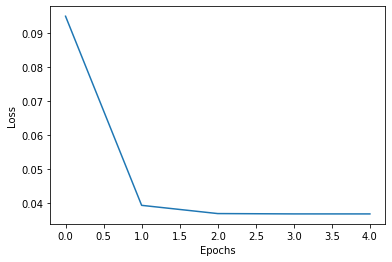

In [44]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Wasserstein with lr=10 decay rate 0.05

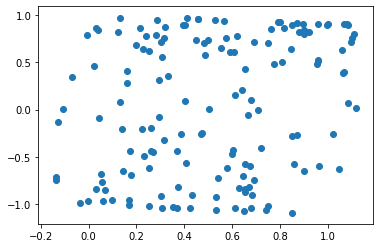

In [22]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=10, dim=1, card = 150)

'''initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)
'''
#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

1.0754668


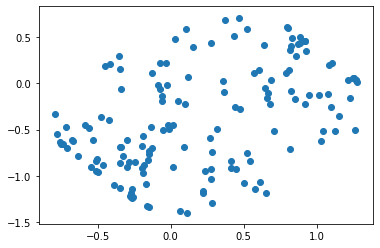

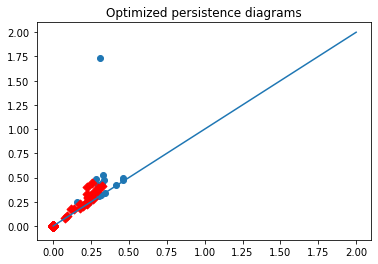

1.0666019


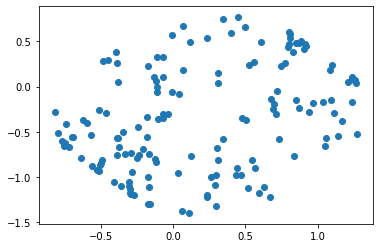

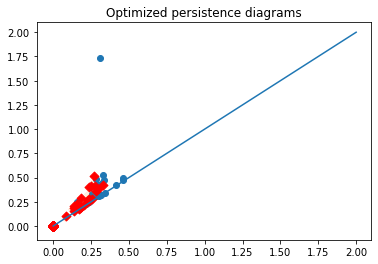

1.0541928


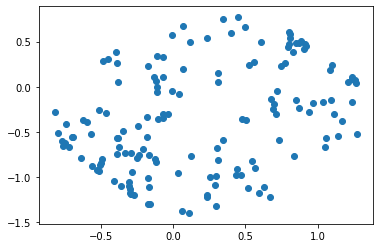

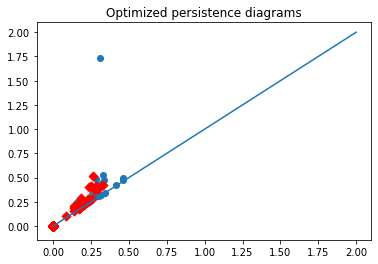

1.0531746


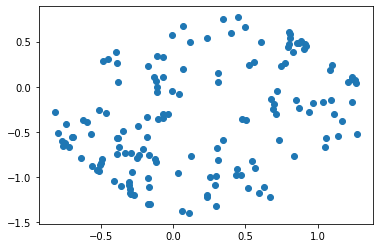

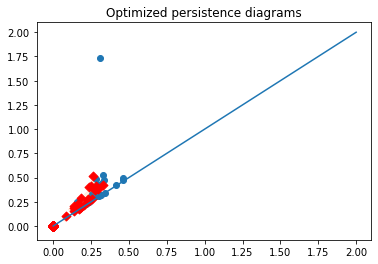

1.0531051


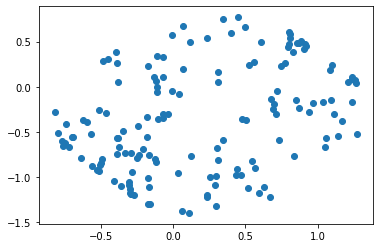

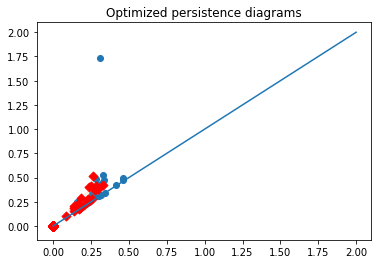

In [23]:
losses, dgms = [], []
lr = 10
for epoch in range(4+1):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]

        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
 
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

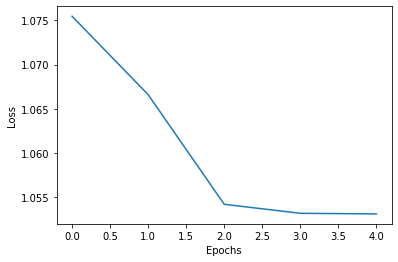

In [24]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Wasserstein with lr=5 decay rate 0.05

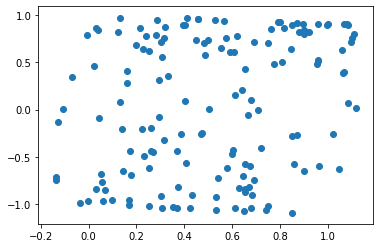

In [25]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)

#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

#sigma=0.1

In [ ]:
losses, dgms = [], []
lr = 5
for epoch in range(20+1):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 2 cylinders CASE 1, lr =5 rate 0.05

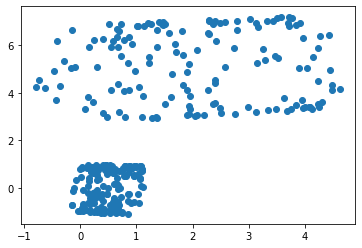

In [67]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)

#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

In [ ]:
losses, dgms = [], []
lr = 5
for epoch in range(10):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 2 cylinders CASE 2

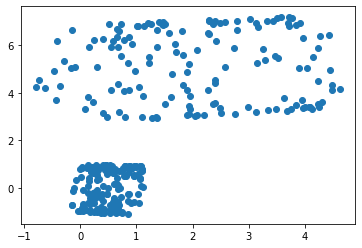

In [65]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)

#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

In [ ]:
losses, dgms = [], []
lr = 5
for epoch in range(10):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

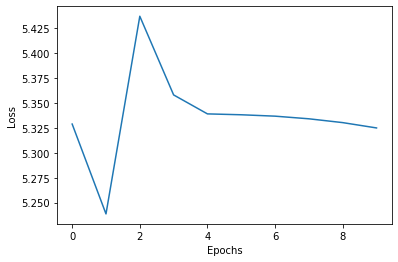

In [52]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## 2 Circles and 6 circles --- dimension reduction

Text(0.5, 1.0, 'Persistence diagram of low dimensional data')

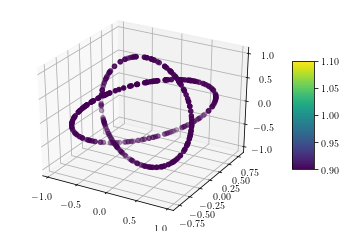

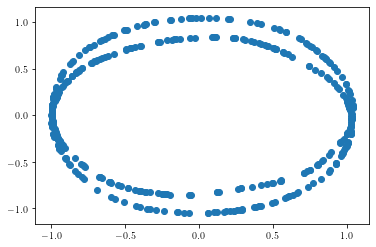

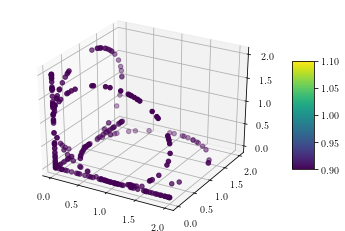

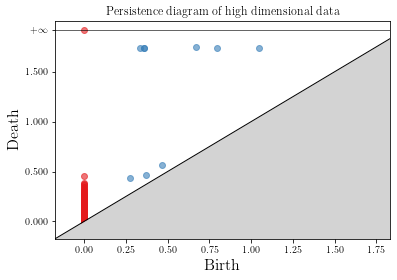

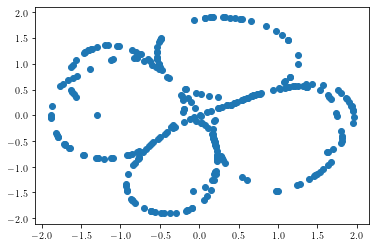

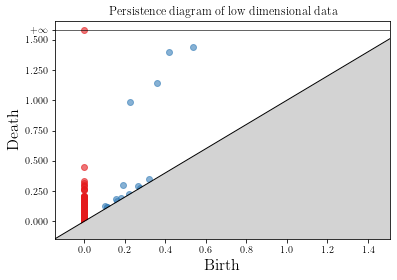

In [30]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 19 14:56:27 2022

@author: olympio
"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import tadasets
import gudhi as gd

def plot3Dmfold(X, Y): #plot a function Y=f(X) as a color map where X 3D array of the points coordinates in the sphere
    fig=plt.figure()
    ax=plt.axes(projection='3d')
    surf=ax.scatter(X[:,0], X[:,1], X[:,2], c=Y)
    fig.colorbar(surf,shrink=0.5, aspect=5)

#%% Data gen interleaved circles
N_pts = 200
X_HD1 = tadasets.dsphere(N_pts, d=1, r=1, ambient = 3) #first circle
X_HD2 = tadasets.dsphere(N_pts, d=1, r=1, ambient = 3) #second circle
X_HD = np.concatenate([X_HD1, X_HD2], axis = 0)

plot3Dmfold(X_HD, np.ones(2*N_pts))
#%% Dim reduc
embedding = MDS(n_components = 2)
X_LD = embedding.fit_transform(X_HD)
plt.figure()
plt.scatter(X_LD[:,0], X_LD[:,1])


#%% 6 orthogonal circles
dim = 4
N_pts = 1000
X_conc=np.zeros((1,dim))
for i in range(dim):
    for j in range(i):
        circle = tadasets.dsphere(N_pts, d=1, r=1)+1
        X_emb = np.zeros((N_pts, dim))
        X_emb[:,i]=circle[:,0]
        X_emb[:,j]=circle[:,1]
        X_conc = np.concatenate([X_conc, X_emb], axis = 0)
X_conc = X_conc[1:,:]

plot3Dmfold(X_conc, np.ones(int(N_pts*dim*(dim-1)/2)))

st_HD = gd.RipsComplex(X_conc).create_simplex_tree(2)
dgm_HD = st_HD.persistence()
gd.plot_persistence_diagram(dgm_HD)
plt.title('Persistence diagram of high dimensional data')

embedding = MDS(n_components = 2) #n_components embedding dimension

X_LD = embedding.fit_transform(X_conc)
plt.figure()
plt.scatter(X_LD[:,0], X_LD[:,1])
#plot3Dmfold(X_LD, np.ones(int(N_pts*dim*(dim-1)/2)))

st_LD = gd.RipsComplex(X_LD).create_simplex_tree(2)
dgm_LD = st_LD.persistence()
gd.plot_persistence_diagram(dgm_LD)
plt.title('Persistence diagram of low dimensional data')

Text(0.5, 1.0, 'Persistence diagram of low dimensional data')

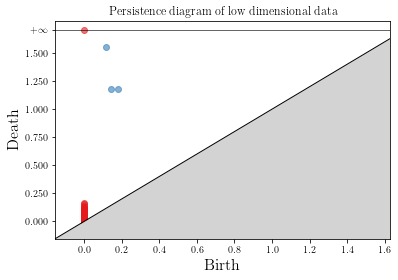

In [36]:
st_LD = gd.RipsComplex(X_HD).create_simplex_tree(2)
dgm_LD = st_LD.persistence()
gd.plot_persistence_diagram(dgm_LD)
plt.title('Persistence diagram of low dimensional data')

In [31]:
X=np.array(X_HD,dtype=np.float32)
X.shape

(400, 3)

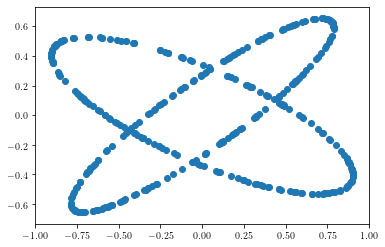

In [32]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

'''initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)
'''
#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

2.1447277


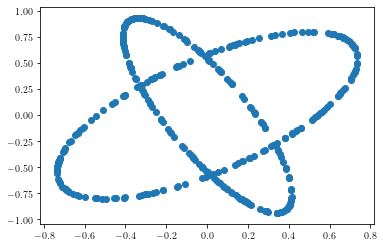

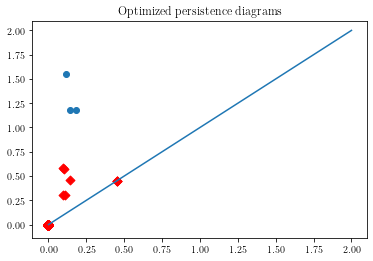

1.8431971


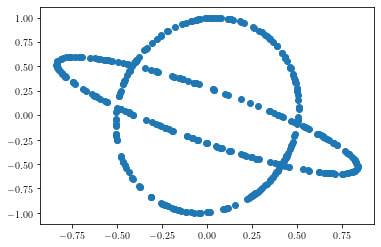

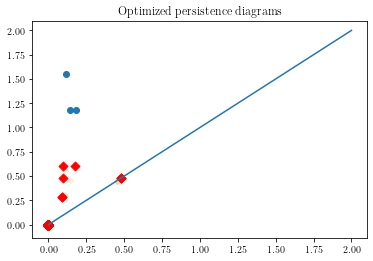

1.7548131


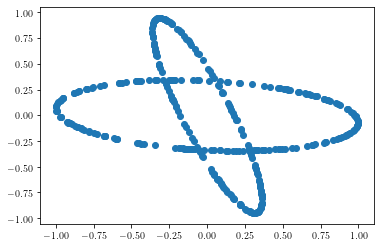

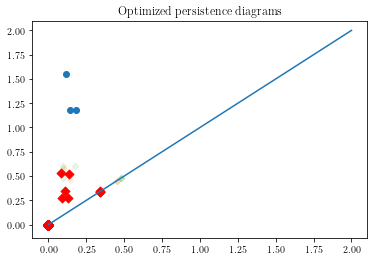

1.9398576


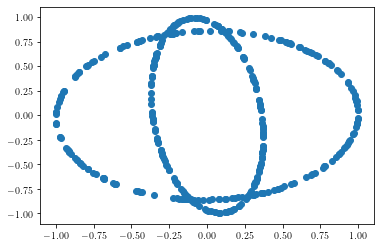

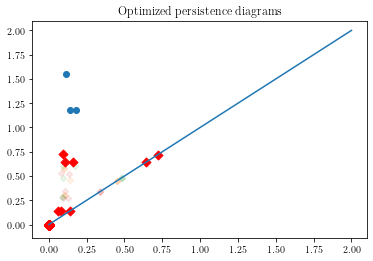

1.2632266


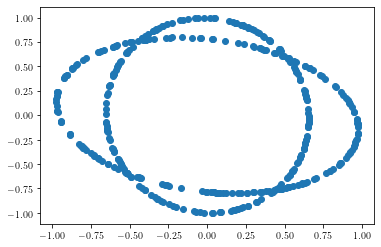

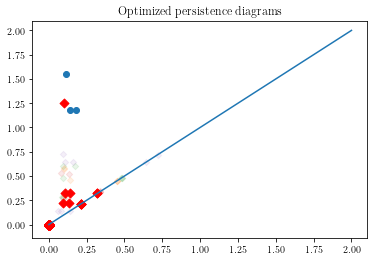

In [33]:
losses, dgms = [], []
lr = 5
for epoch in range(4+1):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.5*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

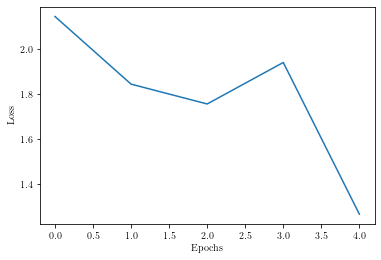

In [34]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [21]:
X=np.array(X_conc,dtype=np.float32)
X.shape

(300, 4)

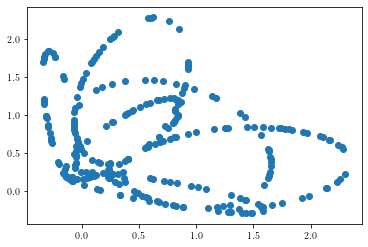

In [22]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(4, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

'''initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)
'''
#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

4.602582


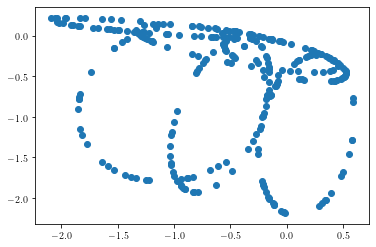

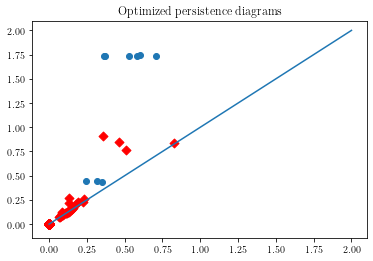

4.1535077


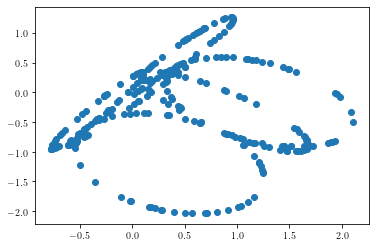

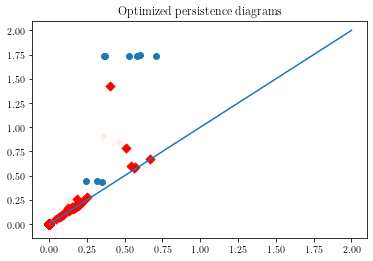

3.6493428


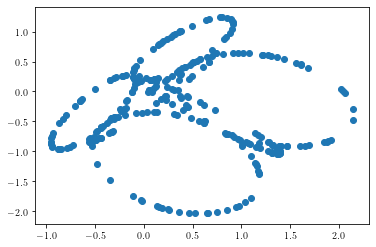

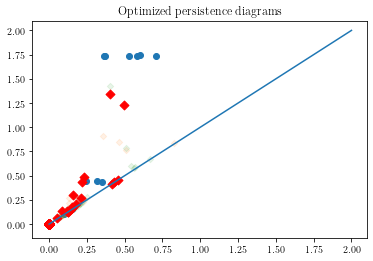

3.0350053


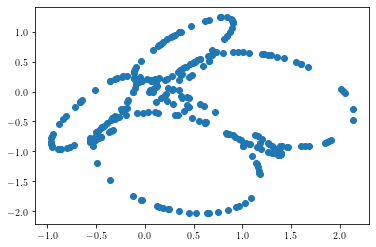

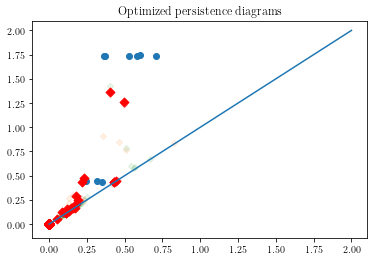

2.9893837


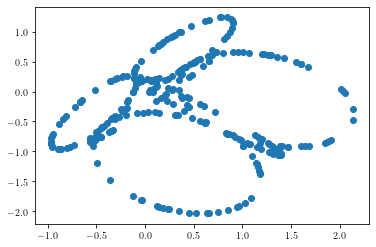

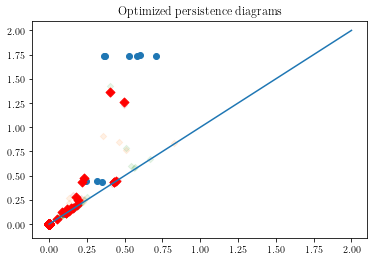

2.9856262


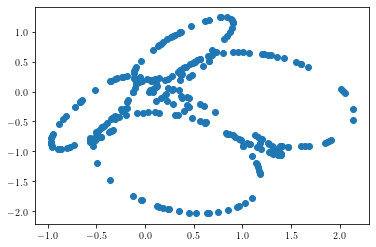

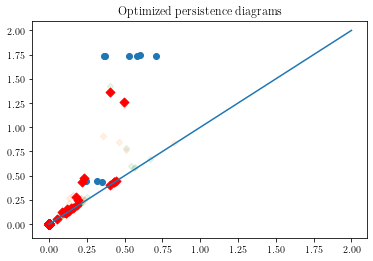

2.9852557


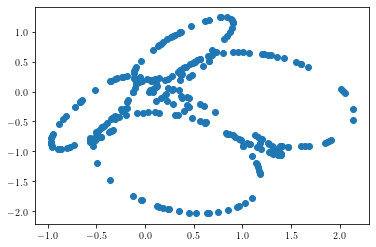

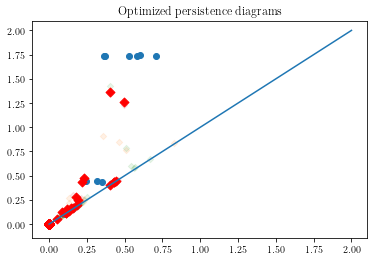

2.9852183


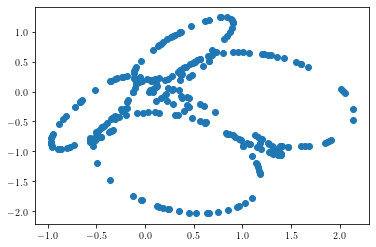

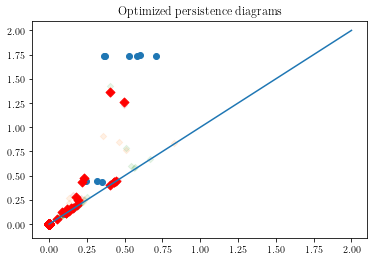

2.9852147


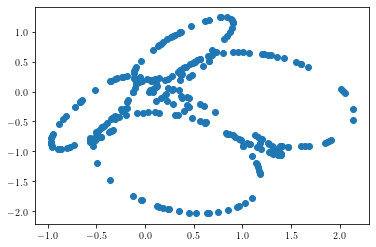

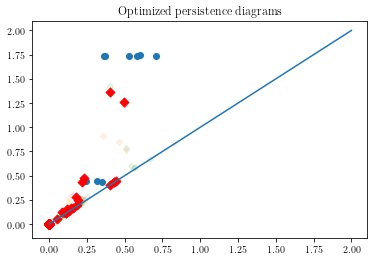

2.9852147


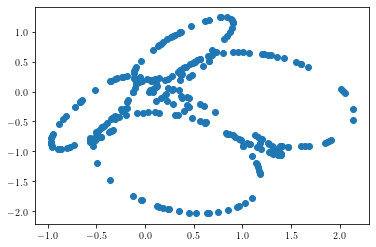

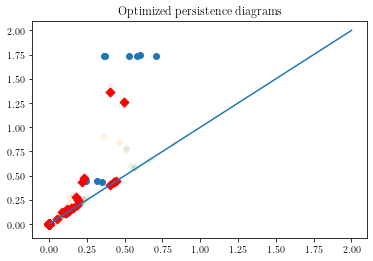

2.9852147


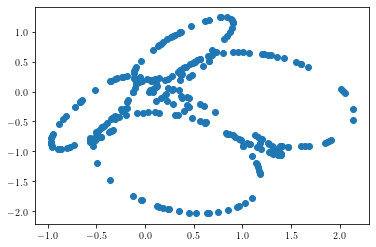

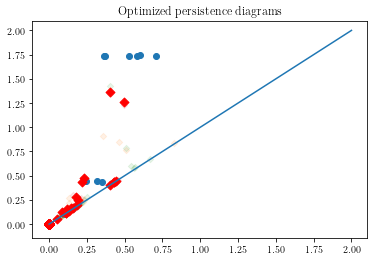

In [23]:
losses, dgms = [], []
lr = 5
for epoch in range(10+1):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.1*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()